In [19]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import hspace, qaoa
from scipy.optimize import minimize
from collections import defaultdict
from qiskit import QuantumCircuit, Aer, execute

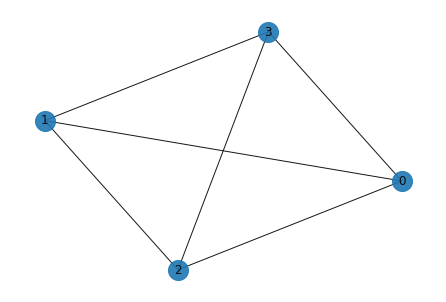

In [20]:
n=4
G = nx.Graph()
G.add_nodes_from(range(n))
G.add_edges_from(hspace.generate_edges(n))
nx.draw(G,with_labels=True,alpha=0.9,node_size=400)

Parity transforms edges in the new dof's. T and S constrains tell us which physical qubits make um 3 and 4-body terms.

In [183]:
T_constraints = hspace.generate_T_constraints(n)
S_constraints = hspace.generate_S_constraints(n)

In [184]:
T_list = [hspace.to_parity_basis(T,n) for T in T_constraints]
S_list = [hspace.to_parity_basis(S,n) for S in S_constraints]

The Hamiltonian comprises of the local field terms J_k \Sigma_z^(k) and Constraints

In [185]:
S_list

[[1, 3, 4, 5]]

In [21]:
def edges_from_constraints(constraint_list):
    edges = []
    for constraint in constraint_list:
        for edge in zip(constraint,displace_list(constraint)):
            edges.append(tuple(sorted(edge)))
        edges.sort()
    return edges

In [48]:
edges_from_constraints(T_list)

[(0, 1), (0, 4), (1, 2), (1, 4), (1, 5), (2, 5)]

In [22]:
def displace_list(a):
    displaced = a[:-1]
    displaced.insert(0,a[-1])
    return displaced

In [23]:
def LHZ_compiled(n):
    k = int(n*(n-1)/2)
    G_LHZ = nx.Graph()
    G_LHZ.add_nodes_from(range(k))
    T_constraints = hspace.generate_T_constraints(n)
    S_constraints = hspace.generate_S_constraints(n)
    T_list = [hspace.to_parity_basis(T,n) for T in T_constraints]
    S_list = [hspace.to_parity_basis(S,n) for S in S_constraints]
    T_edges = edges_from_constraints(T_list)
    S_edges = edges_from_constraints(S_list)
    edges = list(set(T_edges+S_edges))
    G_LHZ.add_edges_from(edges)
    return G_LHZ,T_list,S_list

In [189]:
T_terms

[[0, 1, 4], [1, 2, 5]]

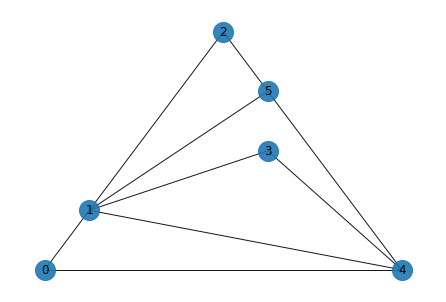

In [187]:
compiled_4,T_terms,S_terms = LHZ_compiled(4)
nx.draw(compiled_4, pos=nx.planar_layout(compiled_4), with_labels=True,alpha=0.9,node_size=400)

With T and S terms we can read off the interaction terms in the LHZ compiled scheme

In [24]:
def add_plaquette_term(qc,omega,sites):
    connections = []
    i=0
    while i<len(sites)-1:
        connections.append((sites[i],sites[i+1]))
        i+=1
    for connection in connections:
        qc.cx(*connection)
    qc.rz(omega,sites[-1])
    for connection in connections[::-1]:
        qc.cx(*connection)

In [25]:
def add_quench_term(qc,theta,qubit):
    qc.rx(theta,qubit)
    pass

In [26]:
def add_local_terms(qc,gamma,k):
    for i in range(k):
        qc.rz(gamma,i)
    pass

In [190]:
constraints = T_list+S_list

In [191]:
qc = QuantumCircuit(6,6)

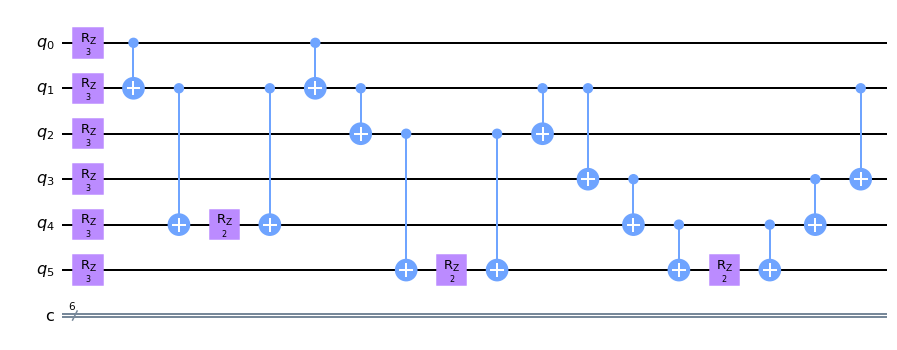

In [192]:
add_local_terms(qc,3,6)
for c in constraints:
    add_plaquette_term(qc,2,c)
qc.draw('mpl')

In [27]:
def get_driver_step(G,theta):
    n_qubits = len(G.nodes)
    driver_unitary = QuantumCircuit(n_qubits,n_qubits)
    for qubit in range(n_qubits):
        add_quench_term(driver_unitary,theta,qubit)
    return driver_unitary

In [28]:
def get_phase_separation_LHZ(G,gamma,omega):
    n_logical = len(G.nodes)
    n_physical = len(G.edges)
    phase_unitary = QuantumCircuit(n_physical,n_physical)
    G_LHZ, T_terms, S_terms  = LHZ_compiled(n_logical)
    constraints = T_terms + S_terms
    add_local_terms(phase_unitary,gamma,n_physical)
    for c in constraints:
        add_plaquette_term(phase_unitary,omega,c)
    return phase_unitary

In [37]:
def LHZ_QAOA_step(G,gamma,theta,omega):
    n_logical = len(G.nodes)
    n_physical = len(G.edges)
    phase_separation_unitary = get_phase_separation_LHZ(G,gamma,omega)
    driver_unitary = get_driver_step(LHZ_compiled(n_logical)[0],theta)
    return phase_separation_unitary.compose(driver_unitary)

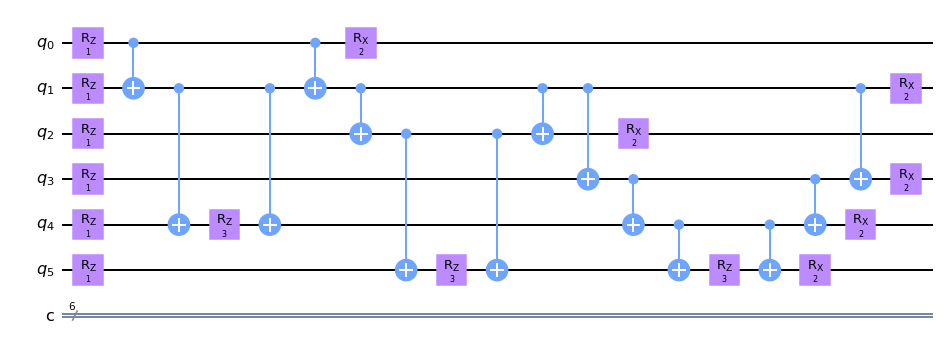

In [38]:
LHZ_QAOA_step(G,1,2,3).draw('mpl')

In [30]:
def get_initial_state(G):
    n_qubits = len(G.nodes)
    initial_state = QuantumCircuit(n_qubits,n_qubits)
    for qubit in range(n_qubits):
        initial_state.h(qubit)
    return initial_state

In [31]:
def LHZ_QAOA(G,p,params):
    n_logical = len(G.nodes)
    n_physical = int(n_logical*(n_logical-1)/2)
    qc = QuantumCircuit(n_physical,n_physical)
    qc = qc.compose(get_initial_state(LHZ_compiled(n_logical)[0]))
    gamma = params[:p]
    theta = params[p:2*p]
    omega = params[2*p:]
    for param in zip(gamma,theta,omega):
        qc = qc.compose(LHZ_QAOA_step(G,*param))   
    qc.barrier(range(n_physical))
    qc.measure(range(n_physical),range(n_physical))
    return qc

In [39]:
n=4
G = nx.Graph()
G.add_nodes_from(range(n))
G.add_edges_from(hspace.generate_edges(n))
params = [1,2,3,4,5,6]
p=2
qc = LHZ_QAOA(G,p,params)

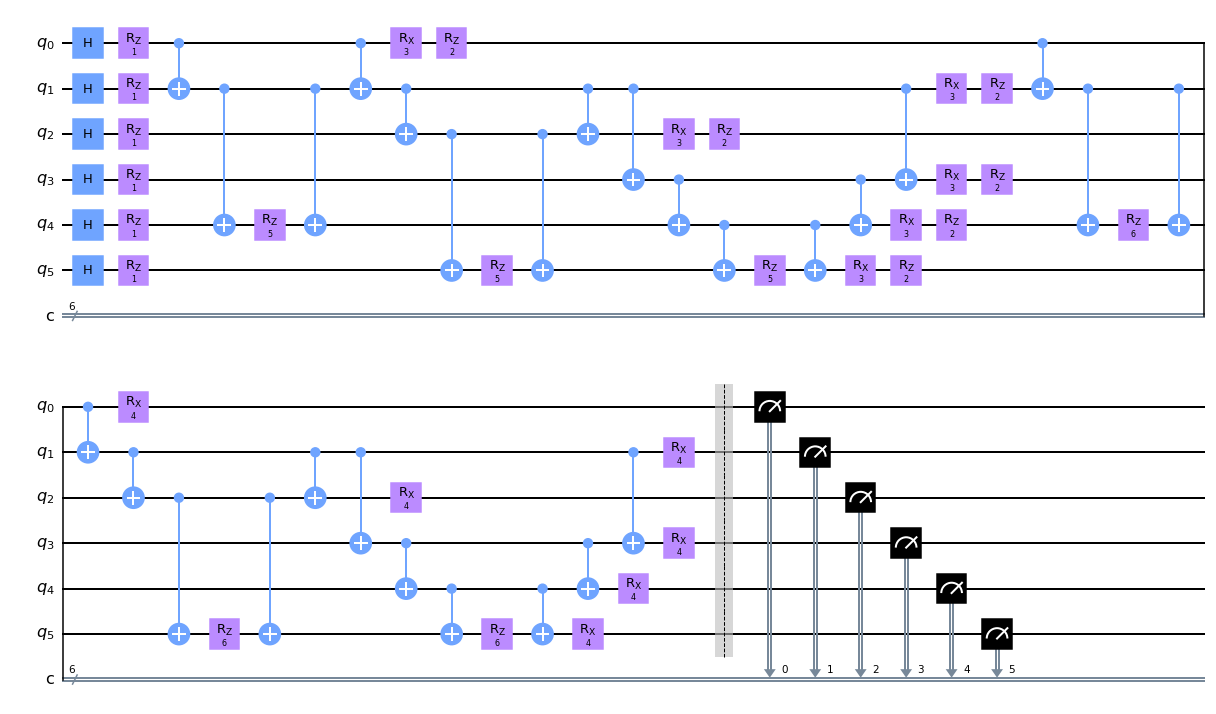

In [40]:
qc.draw('mpl')

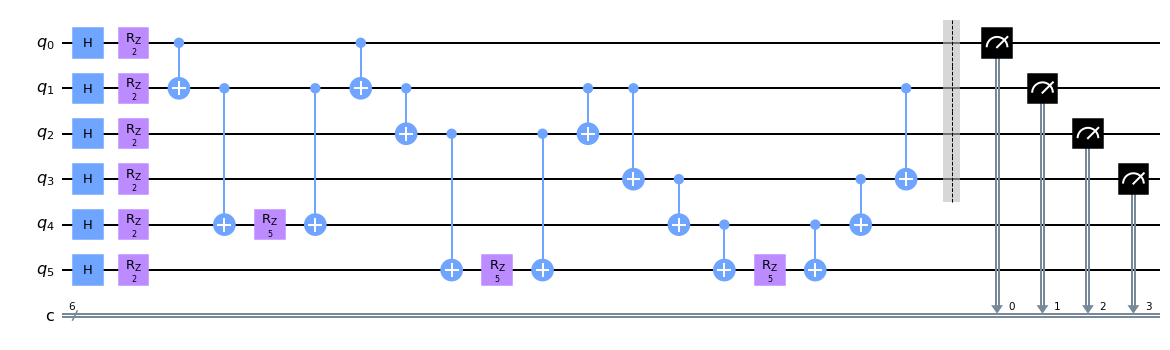

In [41]:
n_logical = 4
n_physical = int(4*3/2)
qc = QuantumCircuit(n_physical,n_physical)
qc = qc.compose(get_initial_state(LHZ_compiled(n_logical)[0]))
qc = qc.compose(get_phase_separation_LHZ(G,2,5))
qc.barrier(range(len(G.nodes)))
qc.measure(range(len(G.nodes)),range(len(G.nodes)))
qc.draw('mpl')

In the parity variables, the objective is just the sum of the site numbers |a,b,c,d,...,>

In [32]:
def objective(state):
    return state.count('1')

In [33]:
def sample_vev(result):
    counts = qaoa.invert_counts(result.get_counts())
    acc = 0
    for state in counts.keys():
        acc+= objective(state)*counts[state]
    counts.values()
    total_counts = 0
    for count in counts.values():
        total_counts += count
    return acc/total_counts

In [42]:
backend  = Aer.get_backend('qasm_simulator')
job = execute(qc,backend)
result = job.result()
print(qaoa.invert_counts(result.get_counts()))

{'101100': 56, '100100': 70, '100000': 52, '010000': 69, '000100': 78, '011100': 62, '110100': 68, '011000': 74, '001000': 54, '101000': 64, '001100': 70, '010100': 59, '111100': 64, '000000': 46, '111000': 68, '110000': 70}


In [43]:
sample_vev(result)

2.0361328125

In [35]:
def LHZ_circuit_objective(G,p,params):
    backend  = Aer.get_backend('qasm_simulator')
    qc = LHZ_QAOA(G,p,params)
    job = execute(qc,backend)
    result = job.result()
    return sample_vev(result)

In [36]:
def black_box_objective(G,p):
    backend  = Aer.get_backend('qasm_simulator')
    def f(params):
        qc = LHZ_QAOA(G,p,params)
        job = execute(qc,backend)
        result = job.result()
        return sample_vev(result)
    return f

In [327]:
LHZ_circuit_objective(G,p,params)

3.0087890625

In [18]:
p = 5
x0=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
print(x0)
minimize_result = minimize(black_box_objective(G,p),x0,method='COBYLA',options={'maxiter':2000,'disp':True})

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


NameError: name 'G' is not defined

In [350]:
minimize_result

     fun: 0.0185546875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 170
  status: 1
 success: True
       x: array([ 3.05939416e-01,  1.08001244e+00,  9.18067549e-01,  8.80847071e-01,
        6.11690122e-01,  7.13746661e-01,  1.65731557e+00,  1.24542938e-01,
       -9.92193419e-02,  5.09748732e-01, -3.31641498e-04,  3.94367814e-02,
       -2.74884132e-01,  8.02494555e-02,  2.93877390e-01])

In [351]:
sol_params = minimize_result['x']
qc = LHZ_QAOA(G,p,sol_params)
backend  = Aer.get_backend('qasm_simulator')
job = execute(qc,backend)
result = job.result()
corrected_counts = qaoa.invert_counts(result.get_counts())

In [352]:
sol_params

array([ 3.05939416e-01,  1.08001244e+00,  9.18067549e-01,  8.80847071e-01,
        6.11690122e-01,  7.13746661e-01,  1.65731557e+00,  1.24542938e-01,
       -9.92193419e-02,  5.09748732e-01, -3.31641498e-04,  3.94367814e-02,
       -2.74884132e-01,  8.02494555e-02,  2.93877390e-01])

In [343]:
corrected_counts

{'000011': 1,
 '100000': 82,
 '000100': 77,
 '011000': 10,
 '010000': 44,
 '000010': 22,
 '001000': 76,
 '110000': 2,
 '001010': 2,
 '000001': 18,
 '100100': 11,
 '101000': 11,
 '001100': 6,
 '000000': 650,
 '110100': 2,
 '010100': 8,
 '100011': 1,
 '011100': 1}

<BarContainer object of 4 artists>

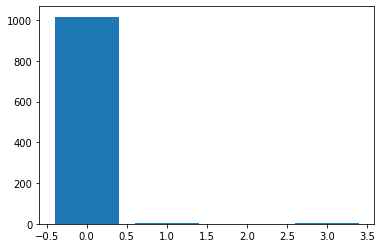

In [297]:
energies = defaultdict(int)
for k, v in corrected_counts.items():
    energies[objective(k)] += v
x,y = zip(*energies.items())
plt.bar(x,y)

In [272]:
logical_basis = hspace.generate_basis(4)
parity_basis = hspace.remove_duplicates([hspace.log_to_phys(state) for state in logical_basis])

In [273]:
parity_basis

[[1, 1, 1, 1, 1, 1],
 [1, 1, 0, 0, 1, 0],
 [1, 0, 0, 1, 0, 1],
 [1, 0, 1, 0, 0, 0],
 [0, 0, 1, 1, 1, 0],
 [0, 0, 0, 0, 1, 1],
 [0, 1, 0, 1, 0, 0],
 [0, 1, 1, 0, 0, 1]]

In [310]:
hspace.log_to_phys([0,1,0,1])

[0, 0, 0, 0, 1, 1]

In [7]:
def initialize_circuit(qc,state):
    i=0
    while i<len(state):
        if int(state[i])==1:
            qc.rx(np.pi,i)
        i+=1

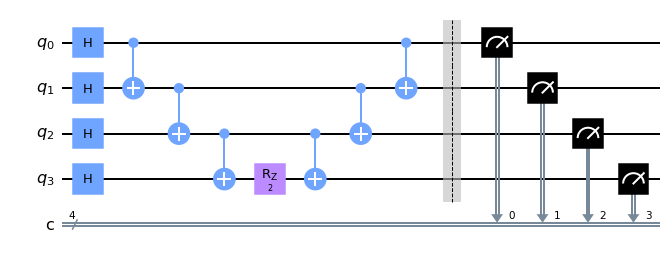

In [14]:
test_qc = QuantumCircuit(4,4)
for qubit in test_qc.qubits:
    test_qc.h(qubit)
add_plaquette_term(test_qc,2,[0,1,2,3])
test_qc.barrier(range(4))
test_qc.measure(range(4),range(4))
test_qc.draw('mpl')

In [15]:
backend  = Aer.get_backend('qasm_simulator')
job = execute(test_qc,backend)
result = job.result()
print(qaoa.invert_counts(result.get_counts()))

{'0111': 43, '1001': 70, '0100': 53, '1101': 56, '0101': 55, '1111': 68, '1110': 78, '1100': 56, '0000': 65, '1011': 59, '0010': 83, '0110': 59, '1000': 69, '0001': 72, '1010': 76, '0011': 62}
